In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 20;


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


In [3]:
### PARAMETERS ###################################
# csv file to load the initial solution
# indices of the best (min TOF) solutions
# maxJC2 : # 327
# velThrust : # 835
# EMrot : #394
# Tidal : #31


ig_file  = "../run/data/diffcorr_0717_TidalThrust.csv"
opt_file = "../run/data/opt_0717_TidalThrust.csv"
dir_func = SailorMoon.dv_tidal_dir_sb1frame
solid = 1
out1 = "optim_traj_tidalThrust.svg"
out2 = "optim_thrust_tidalThrust.svg"


# ig_file  = "../run/data/diffcorr_0618_velThrust.csv"
# opt_file = "../run/data/opt_0618_velThrust.csv"
# dir_func = SailorMoon.dv_vel_dir_sb1frame
# solid = 835
# out1 = "optim_traj_velThrust.svg"
# out2 = "optim_thrust_velThrust.svg"



# ig_file  = "../run/data/diffcorr_0618_maxJCThrust2.csv"
# opt_file = "../run/data/opt_0618_maxJCThrust.csv"
# dir_func = SailorMoon.dv_maxJC_dir_sb1frame
# maxJC2 : # 327
# out1 = "optim_traj_maxJC.svg"
# out2 = "optim_thrust_maxJC.svg"


n_arc = 5


# load initial guess
df_ig  = CSV.read(ig_file, DataFrame; header=0);
df_opt = CSV.read(opt_file, DataFrame; header=0);


### plot the optimized trajectory

In [4]:
position = indexin( solid, df_opt[:,1] )
row_opt = df_opt[position[end],:]

x = Float64.(collect(row_opt[4:end]))
t_, u_, th_, th_nominal  = SailorMoon.x2time_series(x, dir_func, paramMulti, true);
u_array = [u_[:,i] for i in collect(1:size(u_,2))]

θm_lpo = x[19+12*paramMulti.n_arc]  
# thrust_param_nomi = [1.0, 0.0, 0.0]
# th_nominal = get_thrust(t_, u_array, thrust_param_nomi, θm_lpo, dir_func)
# th_nominal = hcat(th_nominal...)

th_mag = vec(mapslices(norm, th_; dims=1))
position = findall(x -> x > 1e-3, th_mag)

u_th = u_[:,position]
th_th = th_[:,position]

3×221 Matrix{Float64}:
 0.938896     0.938439     0.937579    …  0.288315  0.287938  0.287821
 0.344201     0.345444     0.347773       0.957536  0.957649  0.957684
 2.71319e-22  2.72904e-22  2.7587e-22     0.0       0.0       0.0

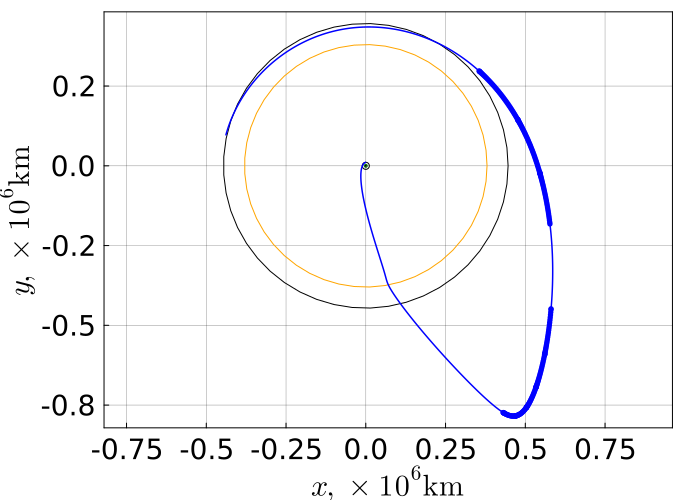

In [5]:
# moon     = SailorMoon.plot_circle(1-param3b.mu2, param3b.as , 0.0)
# earth    = SailorMoon.plot_circle(param3b.mu2, param3b.as, 0.0)
# earth_ub = SailorMoon.plot_circle(param3b.mu2+6375/param3b.lstar, param3b.as, 0.0)
# earth_lb = SailorMoon.plot_circle(param3b.mu2-6375/param3b.lstar, param3b.as, 0.0)
# moon_soi_outer = SailorMoon.plot_circle(1-param3b.mu2+66000/param3b.lstar, param3b.as, 0.0);


moon     = SailorMoon.plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = SailorMoon.plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

p = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-4
);

plot!(p, earth[1,:], earth[2,:], c=:green, lw=1.0, label="")
plot!(p, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="")
plot!(p, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="")
plot!(p, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="")
plot!(p, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6, digits=1))),
    right_margin = 5Plots.mm
)
plot!(p,(u_[1,:].-param3b.as).*param3b.lstar, u_[2,:].*param3b.lstar, c=:blue, lw=1.5, label="optim. traj.")
scatter!(p, (u_th[1,:].-param3b.as).*param3b.lstar, u_th[2,:].*param3b.lstar, c=:blue,
    markersize=3, markerstrokewidth=0, label="")



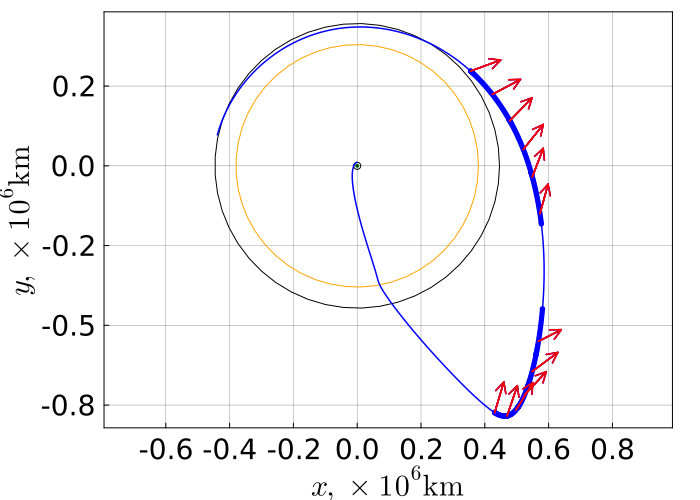

In [10]:
k = size(u_th,2)
m = 20
l = 1e5
quiver!(p,(u_th[1,collect(1:m:k)].-param3b.as).*param3b.lstar, u_th[2,collect(1:m:k)].*param3b.lstar, 
    quiver=(th_th[1,collect(1:m:k)]*l, th_th[2,collect(1:m:k)]*l), c=:red, lw=1.5, label="")

In [7]:
th_th

3×221 Matrix{Float64}:
 0.938896     0.938439     0.937579    …  0.288315  0.287938  0.287821
 0.344201     0.345444     0.347773       0.957536  0.957649  0.957684
 2.71319e-22  2.72904e-22  2.7587e-22     0.0       0.0       0.0

### Now put the initial guess (diff-corr) trajectory 

In [ ]:
position = indexin( solid, df_ig[:,1] )
row_ig = df_ig[position[end],:]
x = Float64.(collect(row_ig[4:end]))
t_ig, u_ig, th_ig, th0_ig  = SailorMoon.x2time_series(x, dir_func, paramMulti, false);
t_days = t_ * param3b.tstar / 86400
t_days = t_days .- t_days[end];  # scale it back to days, and set t_LEO = 0 

In [ ]:
plot!(p,(u_ig[1,:].-param3b.as)*param3b.lstar, u_ig[2,:].*param3b.lstar, c=:lime, lw=1.5, label="ini. guess")
plot!(p, legend=:topright)
plot!(p, xlim=[-0.7e6, 1.3e6])

### thrust history

In [ ]:
p_thrust = plot(
    size=(700,500), frame_style=:box, grid=0.4, legend=false, 
    xlim = [0, 56],
    xlabel=L"t, \textrm{days}", 
    ylabel=L"\textrm{thrust} \ \textrm{angle, deg.}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-5
);

angd = atan.(th_[2,:], th_[1,:])
val = [mod2pi(el)/pi*180 for el in angd]


plot!(p_thrust, t_days, val, c=:blue, lw=1.5, label="optim.")

angd = atan.(th_nominal[2,:], th_nominal[1,:])
val = [mod2pi(el)/pi*180 for el in angd]

plot!(p_thrust, t_days, val, c=:lime, lw=1.5, label="ini.")

plot!(p_thrust, legend=:topleft)

### save

In [ ]:
savefig(p, out1)
savefig(p_thrust, out2)